# Two-dimensional turbulence, operations, and diagnostics

Let's step it up a notch over the last tutorial and consider a _two_-dimensional problem.
To keep the physics simple, we'll just consider freely-decaying two-dimensional turbulence from a random initial state.
So now we will be solving

$$ \partial_t u + \partial_x \left ( u^2 \right ) + \partial_y \left ( uv \right ) + \partial_x p = 0 $$
$$ \partial_t v + \partial_x \left ( u v \right ) + \partial_y \left ( v^2 \right ) + \partial_y p = 0 $$
$$ \partial_x u + \partial_y v = 0 $$

Note that we've included no explicit diffusion. 
That's because we're going to use the fancy `WENO(order=5)` advection scheme introduced in lesson 2, which provides a small amount of diffusion --- just enough to keep the simulation stable.

This can be simulated an alarmingly small number of lines with Oceananigans,

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (8.732 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (17.780 ms).
[ Info: Simulation is stopping after running for 3.669 seconds.
[ Info: Model iteration 400 equals or exceeds stop iteration 400.


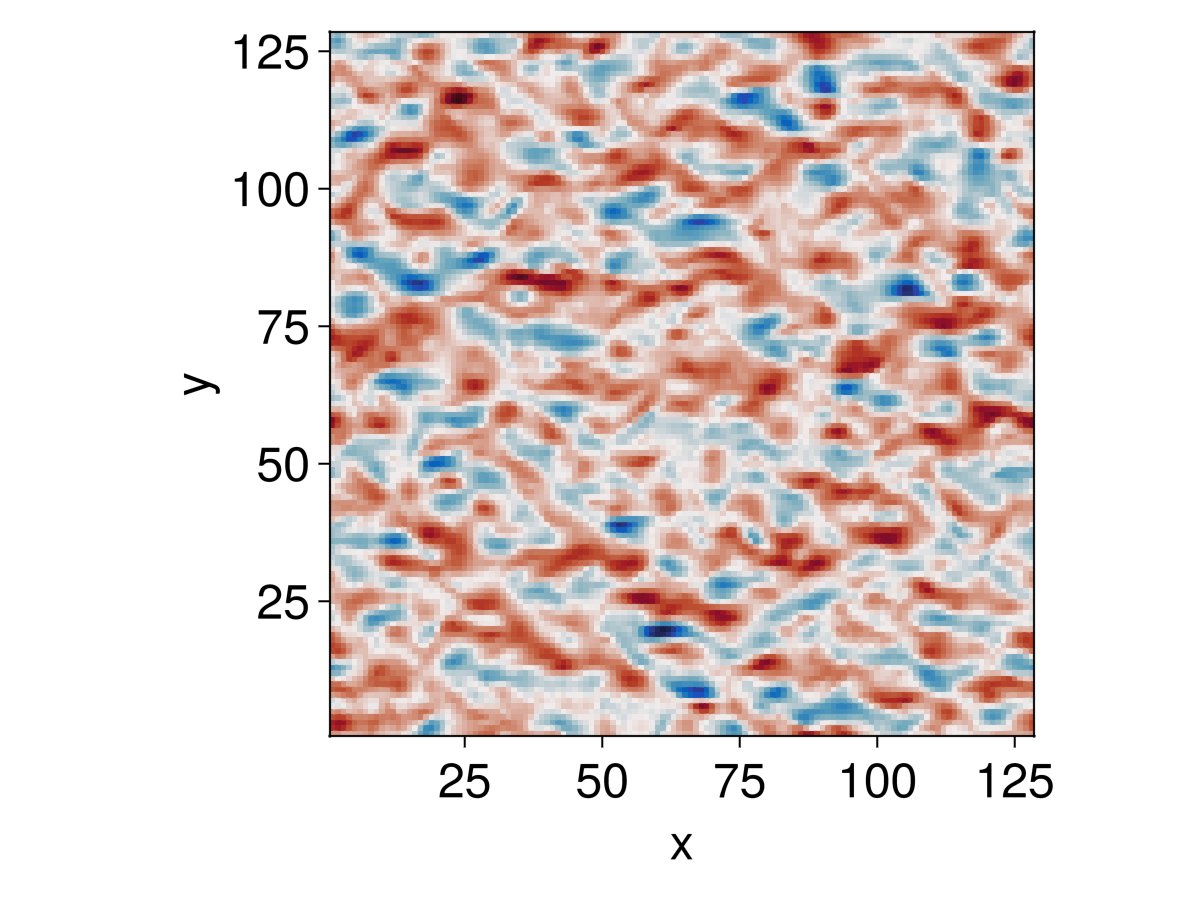

In [17]:
using Oceananigans
using GLMakie
set_theme!(Theme(fontsize=24, linewidth=3))

Nx = Ny = 128
grid = RectilinearGrid(size=(Nx, Ny), x=(0, 1), y=(0, 1), topology=(Periodic, Periodic, Flat))

model = NonhydrostaticModel(; grid, advection=WENO(order=5))
ui(x, y) = randn()
set!(model, u=ui, v=ui)

simulation = Simulation(model, Δt=0.1/Nx, stop_iteration=400)
run!(simulation)

un = interior(model.velocities.u, :, :, 1)
heatmap(un, colormap=:balance, axis=(; aspect=1, xlabel="x", ylabel="y"))

# Operations and diagnostics

Turbulence is great, but it's pointless to simulate it unless we can somehow analyze the results.
To facilitate analysis, Oceananigans has a system for building up expression trees of "operations" --- basically, derivatives, arithmetic, and functions like `sqrt(x)` on a staggered grid --- in terms of Oceananigans fields.
To see what that looks like, let's start by computing the speed in the above model,

In [5]:
u, v, w = model.velocities
s_op = sqrt(u^2 + v^2)

UnaryOperation at (Face, Center, Center)
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
└── tree: 
    sqrt at (Face, Center, Center) via identity
    └── + at (Face, Center, Center)
        ├── ^ at (Face, Center, Center)
        │   ├── 128×128×1 Field{Face, Center, Center} on RectilinearGrid on CPU
        │   └── 2
        └── ^ at (Center, Face, Center)
            ├── 128×128×1 Field{Center, Face, Center} on RectilinearGrid on CPU
            └── 2

The object `s_op` is a `UnaryOperation` --- that is, an operation with one argument.
In this case the operation is `sqrt`, and the argument is itself an operation:

In [6]:
s_op.arg

BinaryOperation at (Face, Center, Center)
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
└── tree: 
    + at (Face, Center, Center)
    ├── ^ at (Face, Center, Center)
    │   ├── 128×128×1 Field{Face, Center, Center} on RectilinearGrid on CPU
    │   └── 2
    └── ^ at (Center, Face, Center)
        ├── 128×128×1 Field{Center, Face, Center} on RectilinearGrid on CPU
        └── 2

namely, of `+`. And so on --- `s_op` is an expression tree that first computes `u^2` and `v^2`, then adds them together, then computes the square root.

An "operation" is a bit like a `Field`, in that we can index into it like so

In [7]:
s_op[1, 1, 1]

0.37365571066433106

But it's also not like a `Field` because it has no underlying data.
In other words, `s_op` is a _lazy_ representation of the expression tree.

Before showing how to actually compute the speed over the whole grid, let's pause for a moment and note that `s_op` has a "location",


In [8]:
location(s_op)

(Face, Center, Center)

which is actually the same location as `u`,

In [9]:
location(u)

(Face, Center, Center)

That's because we built `s_op` without specifying a staggered-grid location, so it took by default the location of the first `Field` argument in the expression tree.
Sometimes living with that default is fine, but other times it's not.
In this case, let's make sure that `s_op` is computed at cell _centers_,s_op = @at (Center, Center, Center) sqrt(u^2 + v^2)


In [10]:
s_op = @at (Center, Center, Center) sqrt(u^2 + v^2)

UnaryOperation at (Center, Center, Center)
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
└── tree: 
    sqrt at (Center, Center, Center) via identity
    └── + at (Center, Center, Center)
        ├── ^ at (Face, Center, Center)
        │   ├── 128×128×1 Field{Face, Center, Center} on RectilinearGrid on CPU
        │   └── 2
        └── ^ at (Center, Face, Center)
            ├── 128×128×1 Field{Center, Face, Center} on RectilinearGrid on CPU
            └── 2

That's better.
Note that `u^2` and `v^2` are both computed at their respective locations, for example,

In [11]:
s_op.arg.a

BinaryOperation at (Face, Center, Center)
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
└── tree: 
    ^ at (Face, Center, Center)
    ├── 128×128×1 Field{Face, Center, Center} on RectilinearGrid on CPU
    └── 2

and it's only when forming the sum of `u^2` and `v^2` that we average these expressions to cell centers.
Generally that's what we want, to delay the averaging as long as possible.

Now we are ready to allocate some memory for _speed_, and then compute it.
To do this we wrap `s_op` in `Field`,

In [12]:
s = Field(s_op)

128×128×1 Field{Center, Center, Center} on RectilinearGrid on CPU
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Periodic, north: Periodic, bottom: Nothing, top: Nothing, immersed: ZeroFlux
├── operand: UnaryOperation at (Center, Center, Center)
├── status: time=0.0
└── data: 134×134×1 OffsetArray(::Array{Float64, 3}, -2:131, -2:131, 1:1) with eltype Float64 with indices -2:131×-2:131×1:1
    └── max=0.0, min=0.0, mean=0.0

Now we have a proper `Field` `s` that has data.
But note that the data is all zero. That's because we don't `compute!` anything unless we really want to --- sometimes `compute!` is expensive.
To actually perform the computation we write

In [13]:
compute!(s)

128×128×1 Field{Center, Center, Center} on RectilinearGrid on CPU
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Periodic, north: Periodic, bottom: Nothing, top: Nothing, immersed: ZeroFlux
├── operand: UnaryOperation at (Center, Center, Center)
├── status: time=0.0
└── data: 134×134×1 OffsetArray(::Array{Float64, 3}, -2:131, -2:131, 1:1) with eltype Float64 with indices -2:131×-2:131×1:1
    └── max=0.831978, min=0.0108621, mean=0.258842

Now we've got something.
Note we could have also used the shorthand `s = compute!(Field(s_op))` to build a `Field` and `compute!` it in a single line.

Next we'll make a vorticity field,

In [40]:
ω_op = ∂x(v) - ∂y(u)
ω = compute!(Field(ω_op))

128×128×1 Field{Face, Face, Center} on RectilinearGrid on CPU
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Periodic, north: Periodic, bottom: Nothing, top: Nothing, immersed: ZeroFlux
├── operand: BinaryOperation at (Face, Face, Center)
├── status: time=0.0
└── data: 134×134×1 OffsetArray(::Array{Float64, 3}, -2:131, -2:131, 1:1) with eltype Float64 with indices -2:131×-2:131×1:1
    └── max=46.5898, min=-43.7634, mean=-1.61329e-16

And finally, plot the results:

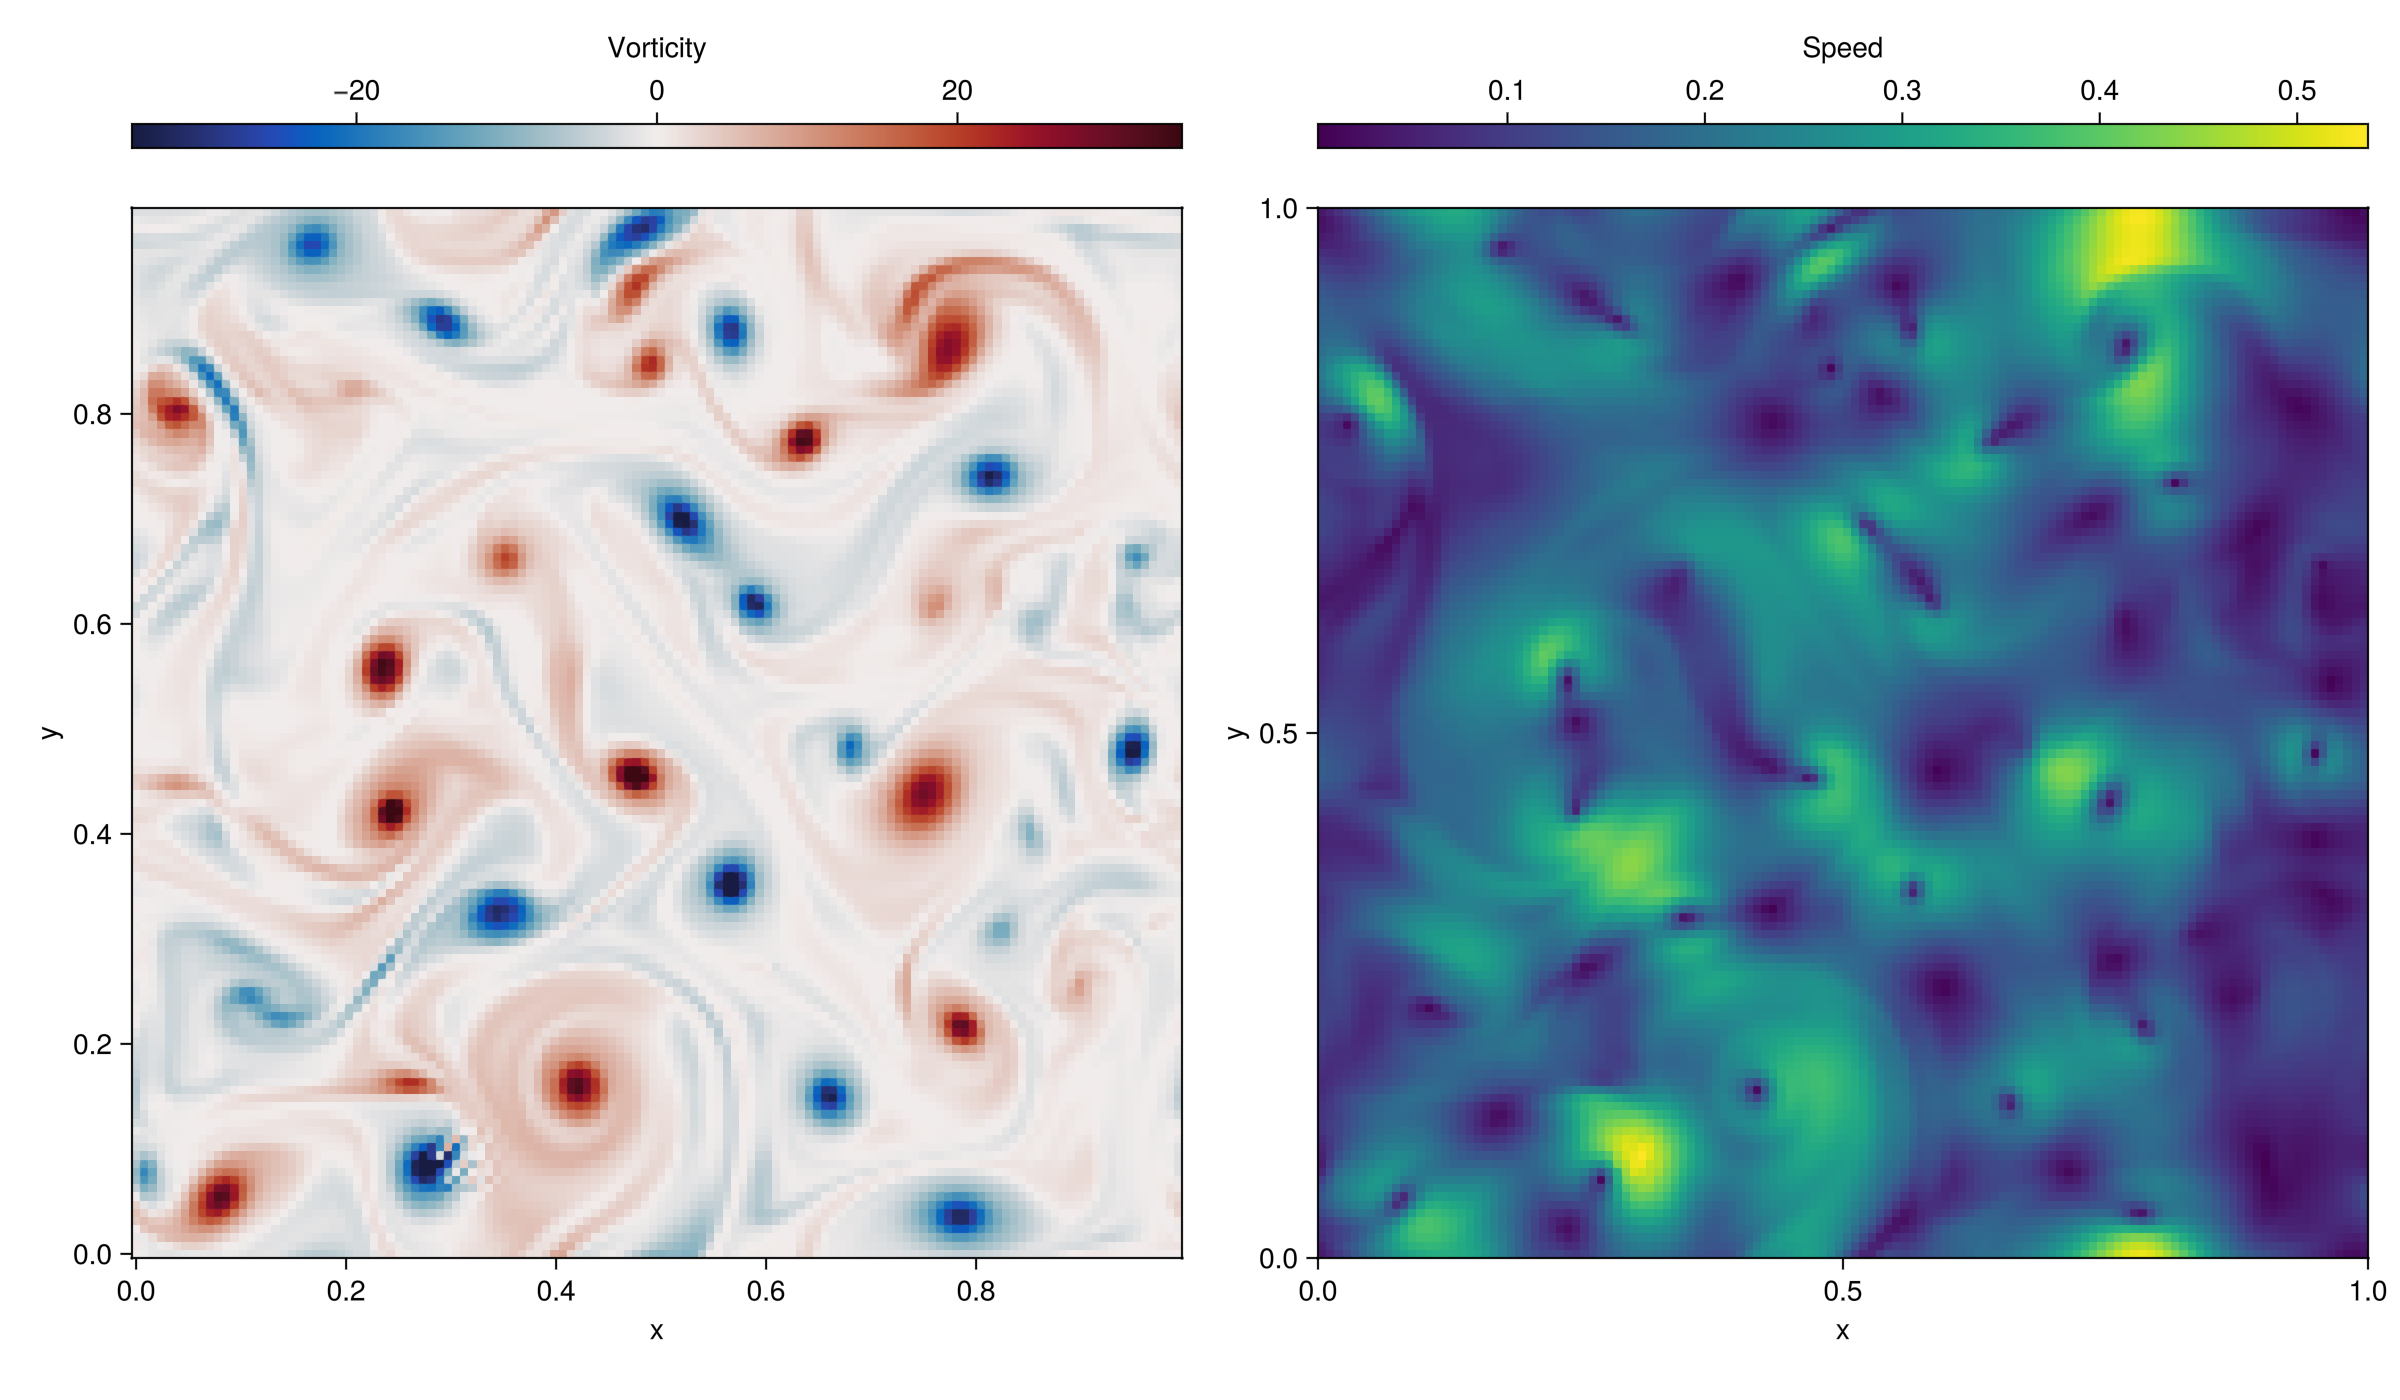

In [41]:
fig = Figure(size=(1200, 700))
axω = Axis(fig[1, 1], xlabel="x", ylabel="y", aspect=1)
axs = Axis(fig[1, 2], xlabel="x", ylabel="y", aspect=1)

ωlim = 3/4 * maximum(abs, ω)
xω, yω, zω = nodes(ω)
hm = heatmap!(axω, xω, yω, interior(ω, :, :, 1), colormap=:balance, colorrange=(-ωlim, ωlim))
Colorbar(fig[0, 1], hm, label="Vorticity", vertical=false)

xs, ys, zs = nodes(s)
hm = heatmap!(axs, xs, ys, interior(s, :, :, 1), colormap=:viridis) 
Colorbar(fig[0, 2], hm, label="Speed", vertical=false)

fig

This system of diagnostics forms the key to interesting output during time-stepping with Oceananigans.

# Adaptive time stepping

In [2]:
using Printf

set!(model, u=ui, v=ui)
model.clock.time = 0
model.clock.iteration = 0

simulation = Simulation(model, Δt=0.1/Nx, stop_iteration=1000)

conjure_time_step_wizard!(simulation, cfl=0.7)

function progress(sim)
    msg = @sprintf("Iter: %d, time: %.2e, Δt: %.2e",
                   iteration(sim), time(sim), sim.Δt)
    @info msg
    return nothing
end

simulation.callbacks[:progress] = Callback(progress, IterationInterval(10))

run!(simulation)

LoadError: UndefVarError: `ui` not defined

In [3]:
compute!(ω)

fig = Figure()
ax = Axis(fig[1, 1], aspect=1)
heatmap!(ax, interior(ω, :, :, 1), colormap=:balance)
fig

LoadError: UndefVarError: `ω` not defined